110250


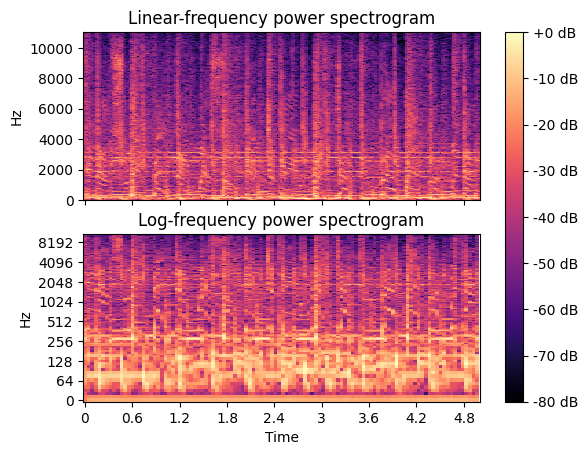

In [35]:
import random
import librosa
import scipy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import IPython.display as ipd
import cv2
# import torch
# import torchaudio
# from torchaudio import transforms

%matplotlib inline

pop_voice = fr"C:\Users\LEGION\PycharmProjects\AudioDataAugmentation\redhot.wav"
y, sr = librosa.load(pop_voice, duration=5)
print(len(y))
# D = librosa.amplitude_to_db(np.abs(librosa.stft(voice_wav)), ref=np.max)
# img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
#                                sr=sr)
# print(voice_wav.shape)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024

D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),

                            ref=np.max)

librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,

                         x_axis='time', ax=ax[1])

ax[1].set(title='Log-frequency power spectrogram')

ax[1].label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")

In [21]:
# hear file
ipd.Audio(y, rate=sr)

In [31]:
start_ = int(np.random.uniform(-30000,30000))
print('time shift: ',start_)
if start_ >= 0:
    wav_time_shift = np.r_[y[start_:], np.random.uniform(-0.01,0.01, start_)]
else:
    wav_time_shift = np.r_[np.random.uniform(-0.01,0.01, -start_), y[:start_]]
ipd.Audio(wav_time_shift, rate=sr)

time shift:  24569


Text(0.5, 1.0, 'Log-frequency power spectrogram')

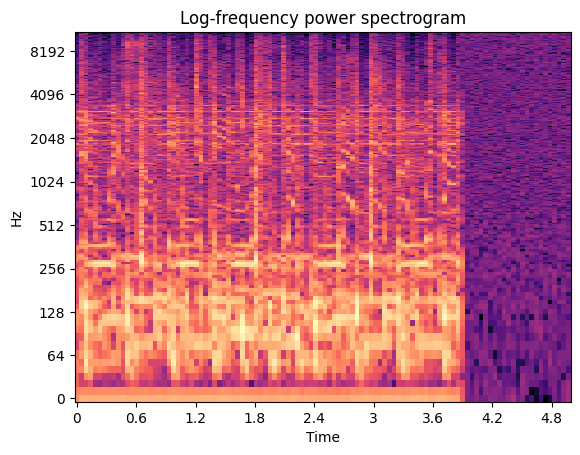

In [32]:
hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(wav_time_shift, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time')
plt.title('Log-frequency power spectrogram')


In [38]:
speed_rate = np.random.uniform(0.7,1.3)
wav_speed_tune = cv2.resize(y, (1, int(len(y) * speed_rate))).squeeze()
print('speed rate: %.3f' % speed_rate, '(lower is faster)')
if len(wav_speed_tune) < len(y):
    pad_len = len(y) - len(wav_speed_tune)
    wav_speed_tune = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),wav_speed_tune,np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
else: 
    cut_len = len(wav_speed_tune) - len(y)
    wav_speed_tune = wav_speed_tune[int(cut_len/2):int(cut_len/2)+1223424]
print('wav length: ', wav_speed_tune.shape[0])
ipd.Audio(wav_speed_tune, rate=sr)

speed rate: 0.926 (lower is faster)
wav length:  110250
